## Problem 3.2: Pulsing jellyfish

In this problem, our goals is to compare and contrast the activities between daytime and nighttime among individual jellyfish, and discuss any changes we see.

Attribution: Zhiyang and Maddie worked on this problem jointly. We all discussed further experimentation together.

In [1]:
import glob
import os

import numpy as np
import pandas as pd
import scipy.signal

# Image processing tools
import skimage
import skimage.io

import bebi103
import altair as alt
import altair_catplot as altcat

import bokeh
bokeh.io.output_notebook()

Loading BokehJS ...

### Load in data

A single jellyfish lives in each box. The boxes are 4 by 4 inches. The jellyfish constantly contract and relax in a pulsing motion. Our task is to measure pulse frequency and see if there are any changes between night and day.

Let's first load in the directories where the image files of the jellyfish are.

In [2]:
# The directory containing daytime data
data_dir = '../data/cassiopea_pulsation/day/'
data_dir_night = '../data/cassiopea_pulsation/night/'

# Glob string for images
im_glob = os.path.join(data_dir, '*.TIF')
im_glob_night = os.path.join(data_dir_night, '*.TIF')

# Get list of files in directory
im_list = sorted(glob.glob(im_glob))
im_list_night = sorted(glob.glob(im_glob_night))

To get a sense of scale for each image, we will click on the boundaries of each 4 by 4 box, compute the length of a side of a box, and then calculate the interpixel distance.

In [3]:
df_clicks = pd.read_csv('../sandbox/clicks_day.csv', index_col=0)
df_clicks_night = pd.read_csv('../sandbox/clicks_night.csv', index_col=0)

In [4]:
box_length = np.sqrt((df_clicks['x'][1] - df_clicks['x'][0])**2 
                     + (df_clicks['y'][1] - df_clicks['y'][0])**2)

box_length_night = np.sqrt((df_clicks_night['x'][1] - df_clicks_night['x'][0])**2 
                     + (df_clicks_night['y'][1] - df_clicks_night['y'][0])**2)

The interpixel distance is then 4 inches / `box_length`.  We will compute it in centimeters.

In [5]:
interpixel_distance = 4 / box_length * 2.54
interpixel_distance_night = 4 / box_length_night * 2.54

In [6]:
interpixel_distance

0.06629178081856157

In [7]:
interpixel_distance_night

0.06628220994865655

Now that we know the interpixel distance, we can display the image with appropriate scaling of axes.

In [8]:
# Read in the image using skimage
im = skimage.io.imread(im_list[0])
im_night = skimage.io.imread(im_list_night[0])

# Let's get information about the image
print(type(im), im.dtype, im.shape)

<class 'numpy.ndarray'> uint16 (480, 640, 3)


In [9]:
# Just slice the red channel since the image is black and white
im = im[:,:,0]
im_night = im_night[:,:,0]

Let's display both the day and the night images.

In [10]:
p1 = bebi103.viz.imshow(im,
                        interpixel_distance=interpixel_distance,
                        length_units='cm')

p2 = bebi103.viz.imshow(im_night,
                        interpixel_distance=interpixel_distance_night,
                        length_units='cm')

p = bokeh.layouts.gridplot([[p1],[p2]])
bokeh.io.show(p)

### Mark ROIs

Now, we're interested in measuring the activities of each jellyfish in each box. To do this, let's define a region of interest around each jellyfish and measure the change in total intensity over time. We have chosen the ROIs to be slightly larger than the jellyfish are currently situated in each box to account for any slight movement or any change in size during contraction and relaxation.

In [11]:
# We've stored the vertices of our ROIs in csv files for easier access.
df_rois = pd.read_csv('../sandbox/roi_day_2.csv', index_col=0)
df_rois_night = pd.read_csv('../sandbox/roi_night_2.csv', index_col=0)

In [12]:
# Take a look
df_rois.head()

roi           x           y
0    0   55.343681  219.857143
1    0  151.840355  225.342857
2    0  151.840355  132.085714
3    0   56.762749  132.085714
4    1  210.022173  208.885714

In [13]:
# Take a look
df_rois_night.head()

roi           x           y
0    0  152.786516  214.814230
1    0   66.223323  209.328516
2    0   66.223323  148.985658
3    0  152.786516  148.985658
4    1  222.320884  191.499944

Now we can use the bebi103 module to convert our list of vertices to ROIs.

In [14]:
rois = [bebi103.image.verts_to_roi(g[['x', 'y']].values, *im.shape) 
            for _, g in df_rois.groupby('roi')]

rois_night = [bebi103.image.verts_to_roi(g[['x', 'y']].values, *im_night.shape) 
            for _, g in df_rois_night.groupby('roi')]

Now that we have defined the ROIs, we can define a loading function that loads the region of the image bounded by the ROI.

In [15]:
# Define load_func that only gives region bounding ROI
def load_roi(fname, roi_bbox=None, **kwargs):
    """
    Image loading function to only load ROI.
    """
    if roi_bbox is None:
        return skimage.io.imread(fname)[:,:,0]
    else:
        return skimage.io.imread(fname)[:,:,0][roi_bbox]
    
ic = skimage.io.ImageCollection(im_glob, conserve_memory=True, 
                            load_func=load_roi)

We know that there are 15 frames per second, so we can adjust our time scale as well.

In [16]:
fps = 15
t = np.arange(0, len(ic)) / fps

### Analysis

Since the jellyfish are dark on a black background, we observe how the total pixel intensity of our respective ROIs change over time to get the pulsing frequency. Since the intensity units are arbitrary, we can subtract the mean and rescale the data so they go from -1 to 1. To find the pulsing frequency, we are specifically interested in the interpulse intervals.

Let's write a couple functions first to find the total intensity and then to calculate the interpulse intervals.

In [17]:
def find_total_intensity(ic, roi_box):
    '''Takes the image and ROI to calculate the total pixel
    intensity over time.'''
    # Set up NumPy array to store total pixel intensity
    total_int = np.empty(len(t))

    # Look through and compute total intensity in the ROI
    for i, im in enumerate(ic):
        total_int[i] = ic[i][roi_box].sum()
    
    total_int -= total_int.mean()
    total_int = 1 + 2 * ((total_int - total_int.max()) 
                    / (total_int.max() - total_int.min()))
    
    return total_int

In [18]:
def find_ipis(data):
    '''Finds the peaks of the signal and calculates
    the intervals between the peaks.'''
    # We've bounded the peaks by a minimum of 0 and a
    # time interval of 2 to make sure that they are real peaks
    peaks = scipy.signal.find_peaks(data, height=0, width=2)
    return np.diff(peaks[0])

Let's first try to compare the activity of one jellyfish in day and night.

In [19]:
# Day
roi, roi_bbox, roi_box = rois[0]

# Load image collection
ic = skimage.io.ImageCollection(im_glob, conserve_memory=True, 
                                load_func=load_roi, roi_bbox=roi_bbox)

# Find total intensity and interpulse intervals
total_int = find_total_intensity(ic, roi_box)
ipis = find_ipis(total_int)

# Night
roi, roi_bbox, roi_box = rois_night[0]

# Load image collection
ic_night = skimage.io.ImageCollection(im_glob_night, conserve_memory=True, 
                                      load_func=load_roi, roi_bbox=roi_bbox)

# Find total intensity and interpulse intervals
total_int_night = find_total_intensity(ic_night, roi_box)
ipis_night = find_ipis(total_int_night)

/Users/madelynw/anaconda3/lib/python3.7/site-packages/skimage/external/tifffile/tifffile.py:2611: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)


We know that there are 15 frames per second, so we can adjust our time scale as well.

In [20]:
fps = 15
t = np.arange(0, len(ic)) / fps

Now let's plot the result.

In [21]:
s1 = bokeh.plotting.figure(plot_width=650,
                           plot_height=300,
                           x_axis_label='time (s)', 
                           y_axis_label='day total intensity')
s1.line(t, total_int, line_width=1, line_join='bevel')

s2 = bokeh.plotting.figure(plot_width=650,
                           plot_height=300,
                           x_axis_label='time (s)', 
                           y_axis_label='night total intensity')
s2.line(t, total_int_night, line_width=1, line_join='bevel')

p = bokeh.layouts.gridplot([[s1],[s2]])
bokeh.io.show(p)

We see immediately that there's a huge difference between day and night. During the day, the jellyfish in the upper left box appears to pulse consistently, but at night, there are long intervals between rapid pulsing. 

Let's first make sure that the calculated peaks look right.

In [22]:
# Day
peaks = scipy.signal.find_peaks(total_int, height=0)

p = bokeh.plotting.figure(plot_width=650,
                          plot_height=300,
                          x_axis_label='time (s)', 
                          y_axis_label='total intensity')

p.line(t, total_int, line_width=2, line_join='bevel')
p.circle(peaks[0]/fps, total_int[peaks[0]], color='orange')

bokeh.io.show(p)

In [23]:
# Night
peaks = scipy.signal.find_peaks(total_int_night, height=0, width=3)

p = bokeh.plotting.figure(plot_width=650,
                          plot_height=300,
                          x_axis_label='time (s)', 
                          y_axis_label='average intensity')

p.line(t, total_int_night, line_width=2, line_join='bevel')
p.circle(peaks[0]/fps, total_int_night[peaks[0]], color='orange')

bokeh.io.show(p)

Zooming in, it seems like there aren't many false peaks with the width setting of scipy.signal.find_peaks equal to 2, and the real peaks are all captured. We'd like to keep this setting.

To look at the interpulse intervals, let's plot the ECDFs. First, let's store our interpulse interval information in a dataframe.

In [24]:
# Combine interpulse interval data for day and night
df_day = pd.DataFrame(ipis, columns={'interpulse_interval'})
df_day['day'] = True

df_night = pd.DataFrame(ipis_night, columns={'interpulse_interval'})
df_night['day'] = False

df_ipis = pd.concat([df_day, df_night])

# Take a look
df_ipis.head()

interpulse_interval   day
0                   13  True
1                   12  True
2                   12  True
3                   12  True
4                   13  True

Now let's plot the ECDFs. Here orange is daytime, and blue is nighttime.

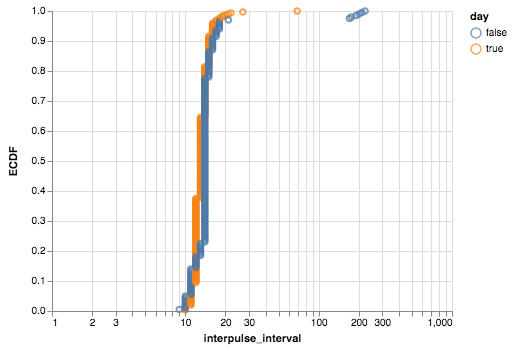

In [25]:
p = altcat.catplot(data=df_ipis,
                   mark='point',
                   encoding=dict(x=alt.X('interpulse_interval:Q', scale=alt.Scale(type='log')),
                                 color=alt.Color('day:N')),
                   transform = 'ecdf')

p

We see that the distribution of interpulse intervals during the day is much more sharp than the distribution of the interpulse intervals at night, suggesting that the jellyfish pulses consistently during the day but has varying pulsing at night. We can see that at night, there are a few long 'rest' periods between periods of pulsing, with interpulse intervals around 200 seconds. At night, the jellyfish also sometimes contracts even faster than during the day.

Now that we've looked at the data for one jellyfish, let's expand this to all 8 jellyfish. We've saved the total intensity and time data in csv files, so let's load that in now.

In [26]:
int_day = np.genfromtxt('../sandbox/day_intotal_all.csv', delimiter=',')
t_day = int_day[-1]
int_day = int_day[0:-1]

int_night = np.genfromtxt('../sandbox/night_intotal_all.csv', delimiter=',')
t_night = int_night[-1]
int_night = int_night[0:-1]

We can plot the activities of all the jellyfish using bokeh's tabbed plots.

In [33]:
tabs_lst = []

for i in range(8):
    s1 = bokeh.plotting.figure(plot_width=650,
                                   plot_height=300,
                                   x_axis_label='time (s)', 
                                   y_axis_label='day total intensity')
    s1.line(t_night, int_day[i], line_width=1, line_join='bevel', color='orange')
    
    s2 = bokeh.plotting.figure(plot_width=650,
                                   plot_height=300,
                                   x_axis_label='time (s)', 
                                   y_axis_label='night total intensity')
    s2.line(t_night, int_night[i], line_width=1, line_join='bevel')
    
    p = bokeh.layouts.gridplot([[s1],[s2]])
    title = "Jellyfish " + str(i+1)
    tab_temp = bokeh.models.widgets.Panel(child=p, title=title)
    
    tabs_lst.append(tab_temp)

tabs = bokeh.models.widgets.Tabs(tabs=tabs_lst)
bokeh.io.show(tabs)

We see that there's large variability between jellyfish during the day and night even between individual jellyfish. Some have longer rest periods during the night than others, and in general the pulsing patterns are quite different between individual jellyfish.

Let's now look at the interpulse intervals, writing a function to return a dataframe with the jellyfish ID attached to the data.

In [28]:
def period_find_day_and_night(i_day, i_night, ID, pheight=0, pwidth=2):
    '''Finds the interpulse intervals for day and night given the 
    intensity data from day and night and jellyfish ID.'''
    # Find peaks during the day
    pulse_peaks,_ = scipy.signal.find_peaks(i_day[ID], height=pheight, width=pwidth)
    dt = np.diff(pulse_peaks)
    df_dt1 = pd.DataFrame(dt)
    df_dt1['day'] = True 
    
    # Find peaks at night
    pulse_peaks,_= scipy.signal.find_peaks(i_night[ID], height=pheight, width=pwidth)
    dt = np.diff(pulse_peaks)
    df_dt2 = pd.DataFrame(dt)
    df_dt2['day'] = False
    
    # Merge the two dataframes
    df_dt = pd.concat([df_dt1, df_dt2])
    df_dt = df_dt.rename(columns={0: 'IPI'})
    
    # Label the jellyfish with an ID
    df_dt['ID'] = ID
    return df_dt

df_dt = period_find_day_and_night(int_day, int_night, ID=0)

for i in range(7):
    df_dt = pd.concat([df_dt, period_find_day_and_night(int_day, int_night, ID=(i+1))])

df_dt = df_dt.reset_index(drop=True)
df_dt.head()

IPI   day  ID
0   13  True   0
1   12  True   0
2   12  True   0
3   12  True   0
4   13  True   0

Now let's plot all the interpulse intervals.

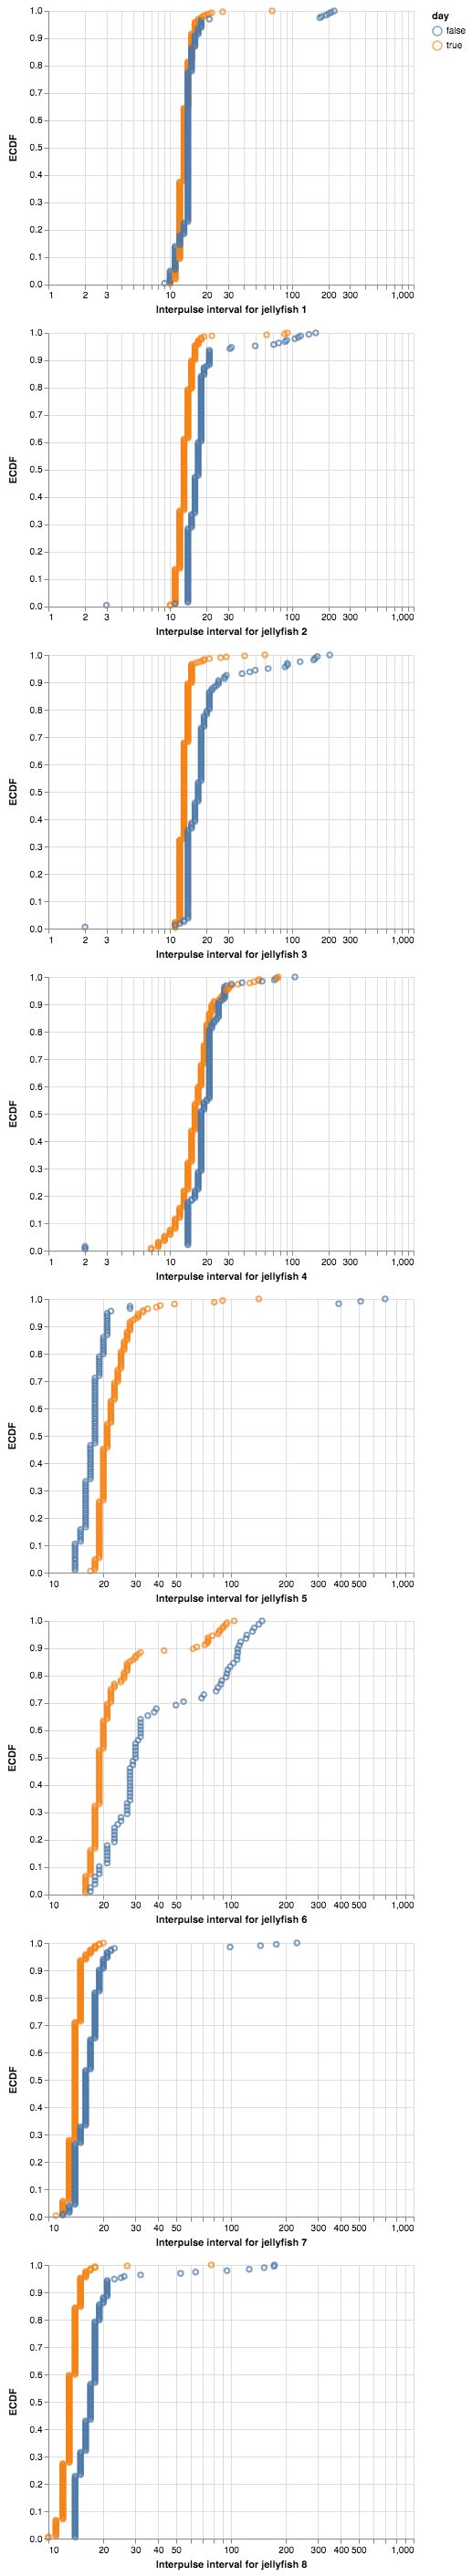

In [29]:
p = []
for i in range(8):
    p_temp = altcat.catplot(data=df_dt.loc[df_dt['ID'] == i, :],
                            mark='point',
                            encoding=dict(x=alt.X('IPI:Q', 
                                          scale=alt.Scale(type='log'),
                                          title='Interpulse interval for jellyfish ' + str(i+1)),
                                          color=alt.Color('day:N')),
                            transform = 'ecdf')
    p.append(p_temp)

# Display all the plots
p[0] & p[1] & p[2] & p[3] & p[4] & p[5] & p[6] & p[7]

Again, we see that each individual jellyfish varies a lot from the others. We also see that the distribution of interpulse intervals during the day is sharper than the distribution of the interpulse intervals at night, suggesting that the jellyfish have some longer IPIs at night. At night, there are longer IPIs than the longest highest IPIs during the day. Some further experiments that can be done are testing how quickly the jellyfish responds to perturbation during the day and night. We could also change the amount of hours they are in the day and night conditions to change their sleep schedule and see how they respond.

## Computing environment

In [30]:
%load_ext watermark

In [31]:
%watermark -v -p numpy,scipy,pandas,skimage,bokeh,bebi103,jupyterlab

CPython 3.7.0
IPython 7.0.1

numpy 1.15.2
scipy 1.1.0
pandas 0.23.4
skimage 0.14.0
bokeh 0.13.0
bebi103 0.0.28
jupyterlab 0.35.0
